# YOLO, YOLO PX, YOLO PX II method analysis and final errors for DS-IC
- Code to estimate Gaussians of images 400 to 599 in the database

In [10]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model_name": "YOLOv0_E3_detect",
}

In [ ]:
# Folders
# Location of images
images_folder = f"../docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"../docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [ ]:
# Path for sample image
n_image = 409
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [11]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [12]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [13]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [20]:
# Training runs (best)
bst_run = {
    "YOLOv0_detect": "2023-07-26_18-50-24",
    "YOLOv0_E2_detect": "2023-08-21_09-27-11",
    "YOLOv0_E3_detect": "2023-08-21_10-25-30",
    "YOLOv0_E4_detect": "2023-08-21_14-37-58",
    "YOLOv0_E12_detect": "2023-08-21_13-57-46",
    "YOLOv0_T80kenji_detect": "2023-09-04_11-19-43",
}

In [21]:
# Load custom model
base_path = "../docs/Models"
model_path = (f"{NOTEBOOK_CONFIG['model_name']}/runs/
              {bst_run[NOTEBOOK_CONFIG['model_name']]}/
              {NOTEBOOK_CONFIG['task']}")

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



In [ ]:
import sys

sys.path.append("..")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import parameters_extract, checkpoint_error
from helpers.aux_plotter import (
    plot_boxes,
    plot_boxes_gmm,
    gaussians_labelled,
    plot_grayscale,
    plot_box_labels,
)
from pipelines.pipelines import (
    ppl_fit_gaussians,
    ppl_error_estimation,
    ppl_yolo_predict_gaussians,
    ppl_yolo_px_predict_gaussians,
    ppl_ensemble_predict_gaussians,
)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [22]:
# Load 400 gaussians
mat = scipy.io.loadmat("../docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [23]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

# [ESTIMATION PART III]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_Yolo

### Predict with custom model - YOLOv0

In [31]:
os.listdir("../docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [32]:
os.listdir("../docs/Models/YOLOv0_E3_detect/datasets/test/images/")

['gaussian_533.png',
 'gaussian_578.png',
 'gaussian_591.png',
 'gaussian_401.png',
 'gaussian_513.png',
 'gaussian_566.png',
 'gaussian_451.png',
 'gaussian_598.png',
 'gaussian_518.png',
 'gaussian_492.png',
 'gaussian_501.png',
 'gaussian_461.png',
 'gaussian_473.png',
 'gaussian_435.png',
 'gaussian_414.png',
 'gaussian_467.png',
 'gaussian_491.png',
 'gaussian_502.png',
 'gaussian_454.png',
 'gaussian_423.png']

In [ ]:
# Wrap sizes and ranges
image_ranges = [(0, NOTEBOOK_CONFIG["IMG_WIDTH"]), (0, NOTEBOOK_CONFIG["IMG_LENGTH"])]
image_size = [NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]]

In [34]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * image_size[0],
        results[0].boxes.xywhn[:, 1] * image_size[1],
    )
]


0: 640x256 85 gaussians, 669.5ms
Speed: 20.1ms preprocess, 669.5ms inference, 35.8ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(15, 20))

# Display the image and plot predicted centers
ax.imshow(im)
plot_boxes(tensor_boxes, ax, edge_color="g")
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

plt.show()

In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat["F_data"][:, :, n_image]]
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=image_ranges,
    image_size=image_size,
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 79


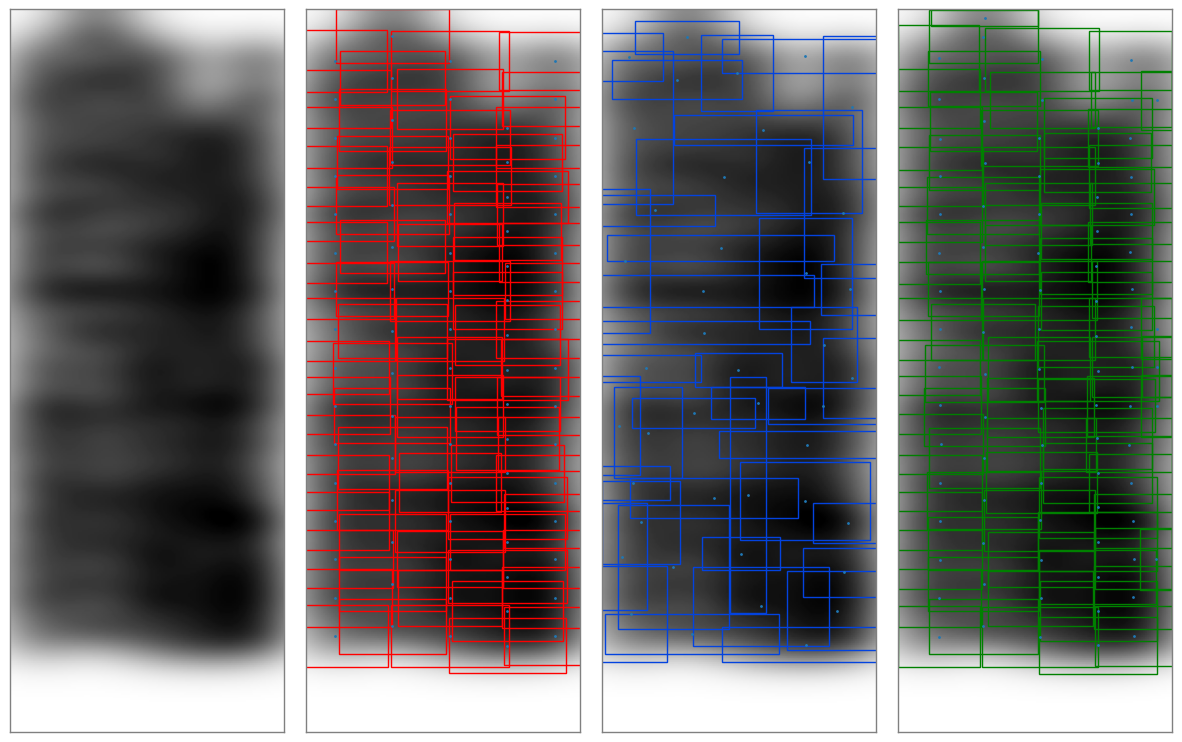

In [35]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize=(15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(
    means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="#0343DF"
)
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes, axs[3], edge_color="g")
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[3].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO": [],
    "Number identifiable - YOLO": [],
    "Percentage - YOLO": [],
    "RMSE_cx - YOLO": [],
    "RMSE_cy - YOLO": [],
    "RMSE_c - YOLO": [],
    "RMSE_sigmax - YOLO": [],
    "RMSE_sigmay - YOLO": [],
    "RMSE_sigma - YOLO": [],
    "MaxE_sigmax - YOLO": [],
    "MaxE_sigmay - YOLO": [],
    "MaxE_sigma - YOLO": [],
    "RMSE_amplitude - YOLO": [],
    "RMSEPixel - YOLO": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO",
        image_path="../Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 297.4ms
Speed: 3.8ms preprocess, 297.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 241.8ms
Speed: 2.2ms preprocess, 241.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 235.4ms
Speed: 2.0ms preprocess, 235.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 236.1ms
Speed: 1.9ms preprocess, 236.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 238.3ms
Speed: 4.2ms preprocess, 238.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 242.4ms
Speed: 4.8ms preprocess, 242.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 1441.8ms
Speed: 6.9ms preprocess, 1441.8ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 1317.8ms
Speed: 4.0ms preprocess, 1317.8ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 936.9ms
Speed: 1.9ms preprocess, 936.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 859.3ms
Speed: 1.9ms preprocess, 859.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 411.0ms
Speed: 2.0ms preprocess, 411.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 393.5ms
Speed: 2.0ms preprocess, 393.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 332.0ms
Speed: 2.8ms preprocess, 332.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 245.7ms
Speed: 1.5ms preprocess, 245.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 233.5ms
Speed: 2.1ms preprocess, 233.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 394.1ms
Speed: 2.0ms preprocess, 394.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 400.2ms
Speed: 1.9ms preprocess, 400.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 387.7ms
Speed: 1.9ms preprocess, 387.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 254.4ms
Speed: 1.9ms preprocess, 254.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 250.3ms
Speed: 1.9ms preprocess, 250.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,120.20,50.49,194.00
Number identified - YOLO,75.45,1.79,78.00
Number identifiable - YOLO,78.60,0.75,80.00
Percentage - YOLO,96.01,2.65,100.00
RMSE_cx - YOLO,1.36,1.28,5.67
RMSE_cy - YOLO,0.31,0.35,1.33
RMSE_c - YOLO,1.40,1.32,5.82
RMSE_sigmax - YOLO,2.78,0.38,3.47
RMSE_sigmay - YOLO,3.30,0.76,4.76
RMSE_sigma - YOLO,4.33,0.77,5.90


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
3,401,85,79,107.59,10.61,0.21,10.61,15.13,3.80,15.60,73.36,73.73,104.01,97.51,5650943.76
14,414,83,79,105.06,11.19,0.19,11.19,14.19,3.73,14.67,75.33,77.29,107.93,102.66,5838305.20
19,423,85,79,107.59,10.67,0.23,10.67,14.43,3.74,14.91,75.57,72.79,104.93,97.01,5700143.42
13,435,83,79,105.06,10.95,0.24,10.95,13.55,3.52,14.00,73.75,75.39,105.46,97.90,5520868.99
6,451,82,79,103.80,10.71,0.23,10.71,13.34,3.48,13.79,73.02,75.48,105.02,99.24,5596370.91
18,454,83,79,105.06,10.75,0.22,10.75,13.38,3.42,13.81,75.97,76.21,107.61,98.66,5533303.13
11,461,83,79,105.06,10.60,0.21,10.60,13.71,3.29,14.10,72.25,74.48,103.77,99.59,5674565.28
15,467,84,79,106.33,10.45,0.22,10.45,14.09,3.57,14.54,77.83,74.38,107.66,99.06,5773734.86
12,473,83,79,105.06,10.81,0.19,10.82,13.41,3.59,13.88,73.57,74.69,104.84,100.05,5711749.48
16,491,84,79,106.33,10.97,0.21,10.97,14.20,3.72,14.68,76.83,71.09,104.68,97.92,5551398.25


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E3YOLO",
)

## [ESTIMATION] Pipeline ppl_SCIKIT_PX
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 84 gaussians, 418.5ms
Speed: 5.5ms preprocess, 418.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means,
    new_covariances,
    amplitudes_px,
    new_means,
    new_covariances_up,
    new_covariances_down,
) = ppl_yolo_px_predict_gaussians(mat, n_image, model, image_path, px_step_size=3)


0: 640x256 84 gaussians, 243.3ms
Speed: 2.5ms preprocess, 243.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 84 gaussians, 258.5ms
Speed: 3.2ms preprocess, 258.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances[:, 0, 0]), np.sqrt(new_covariances[:, 1, 1])
        )
    ],
    ax=ax,
    center_color="b",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=True,
)

In [ ]:
# Plot box and center - YOLO
# Predict
(means, covariances, amplitudes) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)

# Plot box and center
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="b",  # BOX COLOR
    center_color="red",  # CENTER COLOR
    annotate_gaussians=False,
)


0: 640x256 84 gaussians, 299.3ms
Speed: 1.7ms preprocess, 299.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

In [ ]:
adjust_text(all_texts)

9

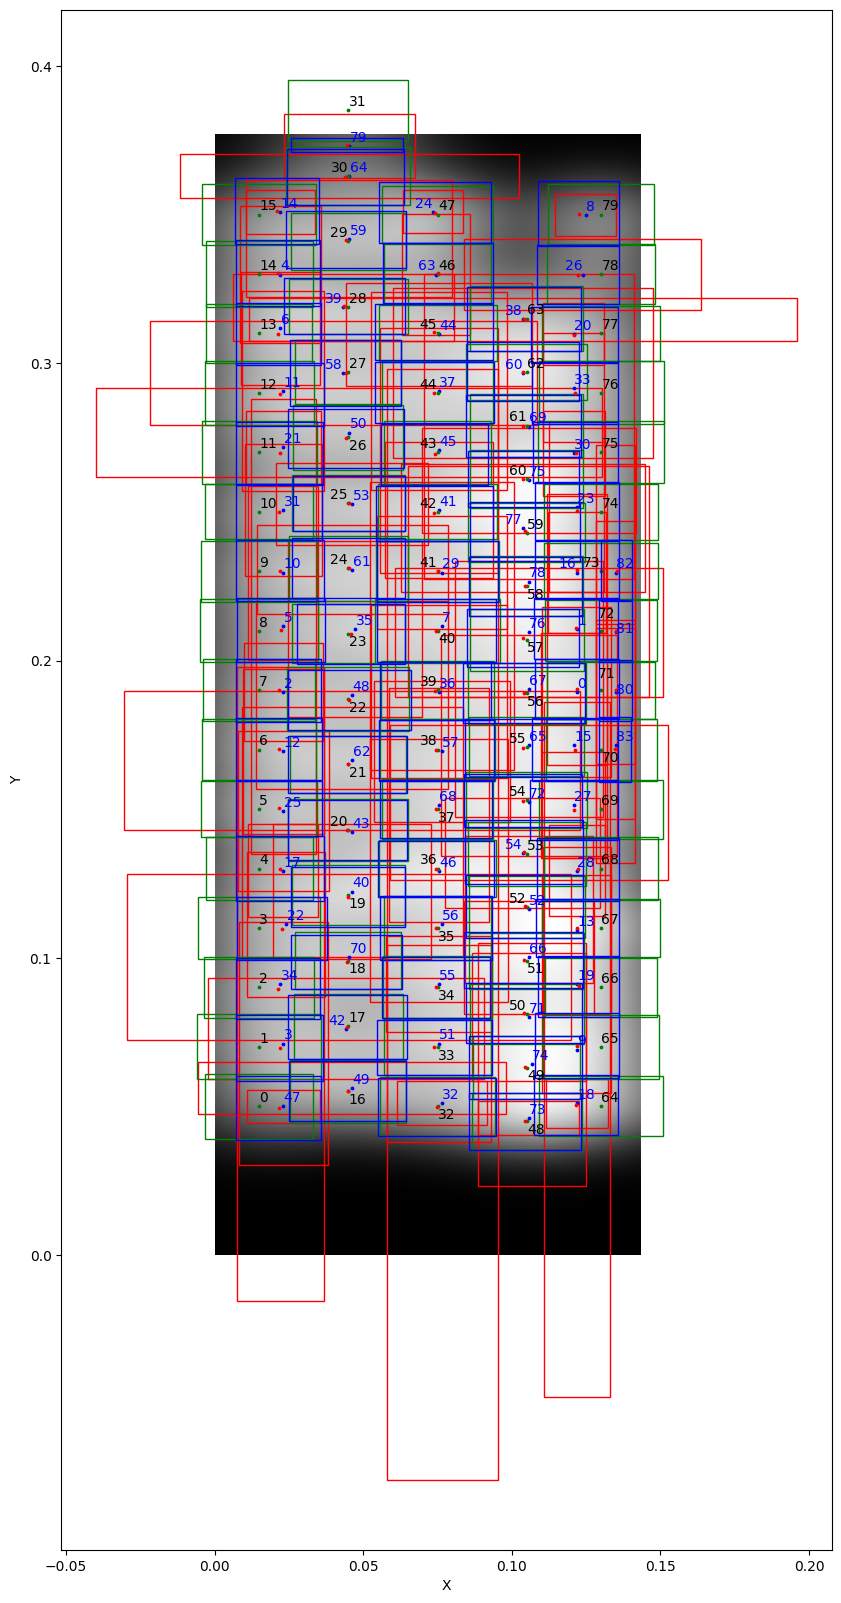

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px": [],
    "Number identifiable - YOLO_px": [],
    "Percentage - YOLO_px": [],
    "RMSE_cx - YOLO_px": [],
    "RMSE_cy - YOLO_px": [],
    "RMSE_c - YOLO_px": [],
    "RMSE_sigmax - YOLO_px": [],
    "RMSE_sigmay - YOLO_px": [],
    "RMSE_sigma - YOLO_px": [],
    "MaxE_sigmax - YOLO_px": [],
    "MaxE_sigmay - YOLO_px": [],
    "MaxE_sigma - YOLO_px": [],
    "RMSE_amplitude - YOLO_px": [],
    "RMSEPixel - YOLO_px": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px",
        image_path="../docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 599.4ms
Speed: 2.2ms preprocess, 599.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017826           0]
  [          0    0.019502]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 415.1ms
Speed: 2.0ms preprocess, 415.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012955           0]
  [          0   0.0094759]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 464.3ms
Speed: 2.0ms preprocess, 464.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014784           0]
  [          0     0.04339]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 479.6ms
Speed: 2.3ms preprocess, 479.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016613           0]
  [          0    0.022448]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 617.8ms
Speed: 2.9ms preprocess, 617.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015537           0]
  [          0     0.11685]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 372.6ms
Speed: 1.9ms preprocess, 372.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014831           0]
  [          0    0.019934]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 375.6ms
Speed: 3.6ms preprocess, 375.6ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015816           0]
  [          0     0.14678]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 395.1ms
Speed: 1.9ms preprocess, 395.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015544           0]
  [          0     0.04375]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 395.6ms
Speed: 2.0ms preprocess, 395.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015753           0]
  [          0    0.058006]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 364.7ms
Speed: 2.6ms preprocess, 364.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.017401           0]
  [          0     0.06325]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 234.7ms
Speed: 2.0ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014262           0]
  [          0    0.040412]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 238.1ms
Speed: 2.1ms preprocess, 238.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018042           0]
  [          0    0.061691]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 408.5ms
Speed: 1.9ms preprocess, 408.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013425           0]
  [          0    0.010802]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 400.8ms
Speed: 1.9ms preprocess, 400.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019762           0]
  [          0    0.018935]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 425.3ms
Speed: 4.8ms preprocess, 425.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016188           0]
  [          0    0.039202]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 415.4ms
Speed: 2.0ms preprocess, 415.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.018737           0]
  [          0    0.067357]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 316.4ms
Speed: 1.8ms preprocess, 316.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018149           0]
  [          0    0.043053]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 229.5ms
Speed: 2.6ms preprocess, 229.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014386           0]
  [          0    0.026032]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 235.9ms
Speed: 2.4ms preprocess, 235.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01676           0]
  [          0    0.022481]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 237.1ms
Speed: 1.9ms preprocess, 237.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016568           0]
  [          0    0.018677]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,493.10,58.18,598.00
Number identified - YOLO_px,83.95,2.19,89.00
Number identifiable - YOLO_px,79.00,0.00,79.00
Percentage - YOLO_px,106.26,2.77,112.66
RMSE_cx - YOLO_px,12.67,0.34,13.28
RMSE_cy - YOLO_px,0.71,0.04,0.80
RMSE_c - YOLO_px,12.69,0.34,13.30
RMSE_sigmax - YOLO_px,71.47,15.08,98.78
RMSE_sigmay - YOLO_px,161.26,20.28,189.74
RMSE_sigma - YOLO_px,177.04,19.97,204.23


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E3YOLOPX",
)

## Evaluate - Plot Truth, YOLO and PX infer

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means_infer],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances_infer[:, 0, 0]),
            np.sqrt(new_covariances_infer[:, 1, 1]),
        )
    ],
    ax=ax,
    center_color="b",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=True,
)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="b",  # BOX COLOR
    center_color="red",  # CENTER COLOR
    annotate_gaussians=False,
)

In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

In [ ]:
adjust_text(all_texts)

6

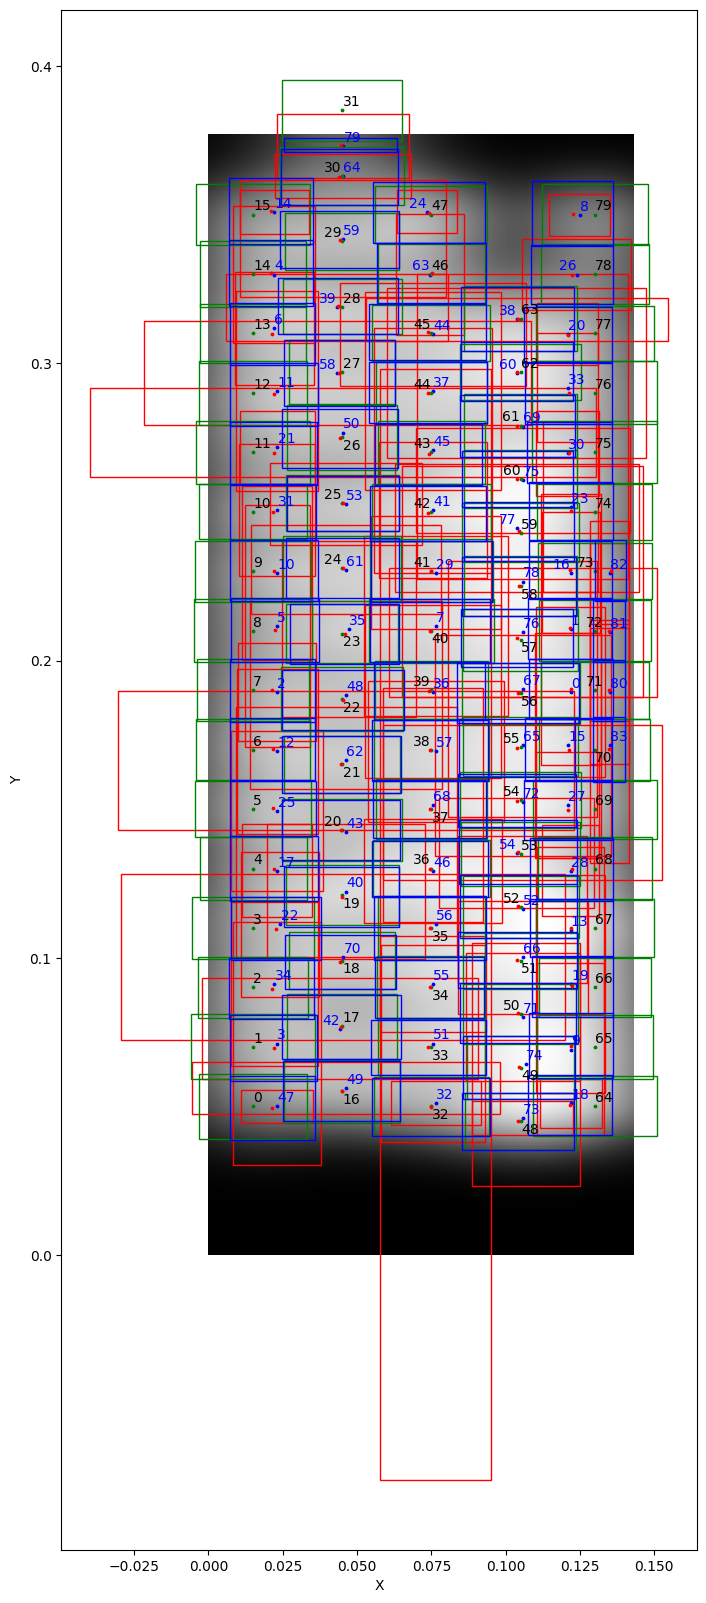

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Modified 2

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px_infer": [],
    "Number identifiable - YOLO_px_infer": [],
    "Percentage - YOLO_px_infer": [],
    "RMSE_cx - YOLO_px_infer": [],
    "RMSE_cy - YOLO_px_infer": [],
    "RMSE_c - YOLO_px_infer": [],
    "RMSE_sigmax - YOLO_px_infer": [],
    "RMSE_sigmay - YOLO_px_infer": [],
    "RMSE_sigma - YOLO_px_infer": [],
    "MaxE_sigmax - YOLO_px_infer": [],
    "MaxE_sigmay - YOLO_px_infer": [],
    "MaxE_sigma - YOLO_px_infer": [],
    "RMSE_amplitude - YOLO_px_infer": [],
    "RMSEPixel - YOLO_px_infer": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px_infer",
        image_path="../docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 310.3ms
Speed: 2.2ms preprocess, 310.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017826           0]
  [          0    0.019502]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 243.2ms
Speed: 2.1ms preprocess, 243.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012955           0]
  [          0   0.0094759]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 245.0ms
Speed: 1.5ms preprocess, 245.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014784           0]
  [          0     0.04339]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 443.8ms
Speed: 3.1ms preprocess, 443.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016613           0]
  [          0    0.022448]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 578.4ms
Speed: 2.0ms preprocess, 578.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015537           0]
  [          0     0.11685]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 487.8ms
Speed: 2.2ms preprocess, 487.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014831           0]
  [          0    0.019934]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 412.7ms
Speed: 2.7ms preprocess, 412.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015816           0]
  [          0     0.14678]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 381.9ms
Speed: 2.1ms preprocess, 381.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015544           0]
  [          0     0.04375]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 240.3ms
Speed: 2.0ms preprocess, 240.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015753           0]
  [          0    0.058006]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 233.6ms
Speed: 1.5ms preprocess, 233.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.017401           0]
  [          0    0.030196]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 229.4ms
Speed: 1.5ms preprocess, 229.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014262           0]
  [          0    0.040412]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 237.4ms
Speed: 1.9ms preprocess, 237.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018042           0]
  [          0    0.061691]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 237.0ms
Speed: 3.0ms preprocess, 237.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013425           0]
  [          0    0.010802]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 229.5ms
Speed: 2.5ms preprocess, 229.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019762           0]
  [          0    0.018935]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 226.7ms
Speed: 2.2ms preprocess, 226.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016188           0]
  [          0    0.039202]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 248.8ms
Speed: 2.4ms preprocess, 248.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.018737           0]
  [          0    0.067357]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 234.7ms
Speed: 4.3ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018149           0]
  [          0    0.043053]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 230.7ms
Speed: 1.9ms preprocess, 230.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014386           0]
  [          0    0.026032]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 230.8ms
Speed: 1.5ms preprocess, 230.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01676           0]
  [          0    0.022481]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 241.8ms
Speed: 1.9ms preprocess, 241.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016568           0]
  [          0    0.018677]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,493.10,58.18,598.00
Number identified - YOLO_px_infer,83.95,2.19,89.00
Number identifiable - YOLO_px_infer,79.00,0.00,79.00
Percentage - YOLO_px_infer,106.26,2.77,112.66
RMSE_cx - YOLO_px_infer,12.67,0.34,13.28
RMSE_cy - YOLO_px_infer,0.71,0.04,0.80
RMSE_c - YOLO_px_infer,12.69,0.34,13.30
RMSE_sigmax - YOLO_px_infer,61.58,11.88,94.48
RMSE_sigmay - YOLO_px_infer,132.21,16.45,159.29
RMSE_sigma - YOLO_px_infer,146.28,16.70,183.52


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E3YOLOPXINFER",
)

## [ESTIMATION] Pipeline ensembled (PX Modified and YOLO)

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image, converted_new_means, list(new_covariances / 2), amplitudes_px
)

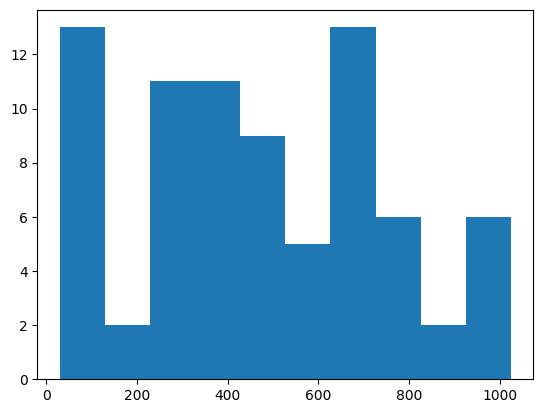

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


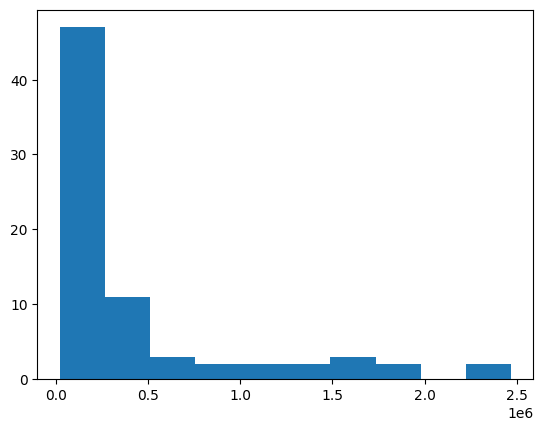

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}")

Max error gaussian = 70
Min error gaussian = 27


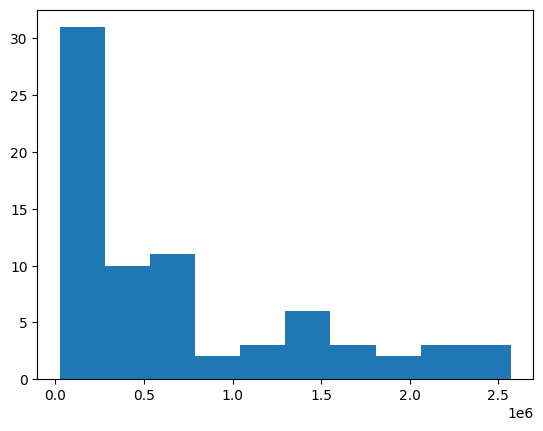

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_px))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_px))}")

### Error evaluation ensemble Yolo and PX modified

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="../docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 518.3ms
Speed: 2.5ms preprocess, 518.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 419.7ms
Speed: 2.0ms preprocess, 419.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 411.4ms
Speed: 1.8ms preprocess, 411.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 417.2ms
Speed: 1.9ms preprocess, 417.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 251.3ms
Speed: 1.9ms preprocess, 251.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 232.7ms
Speed: 2.9ms preprocess, 232.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 228.5ms
Speed: 2.2ms preprocess, 228.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 234.1ms
Speed: 3.7ms preprocess, 234.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 241.3ms
Speed: 3.7ms preprocess, 241.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 244.9ms
Speed: 2.5ms preprocess, 244.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 395.1ms
Speed: 2.4ms preprocess, 395.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 798.1ms
Speed: 5.4ms preprocess, 798.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 1655.0ms
Speed: 2.0ms preprocess, 1655.0ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 809.9ms
Speed: 1.9ms preprocess, 809.9ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 394.8ms
Speed: 2.7ms preprocess, 394.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 375.9ms
Speed: 2.7ms preprocess, 375.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 382.2ms
Speed: 1.9ms preprocess, 382.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 396.3ms
Speed: 2.1ms preprocess, 396.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 234.8ms
Speed: 1.8ms preprocess, 234.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 89 gaussians, 235.8ms
Speed: 2.0ms preprocess, 235.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 247.2ms
Speed: 4.8ms preprocess, 247.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 237.8ms
Speed: 1.8ms preprocess, 237.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 406.4ms
Speed: 1.9ms preprocess, 406.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 403.4ms
Speed: 1.9ms preprocess, 403.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 410.4ms
Speed: 1.9ms preprocess, 410.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 232.4ms
Speed: 1.6ms preprocess, 232.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 250.4ms
Speed: 5.5ms preprocess, 250.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 231.6ms
Speed: 2.8ms preprocess, 231.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 238.5ms
Speed: 2.1ms preprocess, 238.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 236.8ms
Speed: 2.0ms preprocess, 236.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 235.9ms
Speed: 1.9ms preprocess, 235.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 235.7ms
Speed: 1.9ms preprocess, 235.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 240.6ms
Speed: 2.2ms preprocess, 240.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 226.2ms
Speed: 2.5ms preprocess, 226.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 229.5ms
Speed: 2.0ms preprocess, 229.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 232.5ms
Speed: 2.0ms preprocess, 232.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 230.0ms
Speed: 2.0ms preprocess, 230.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 232.3ms
Speed: 2.1ms preprocess, 232.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 1043.7ms
Speed: 1.8ms preprocess, 1043.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 507.5ms
Speed: 1.9ms preprocess, 507.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,493.10,58.18,598.00
Number identified - ensembled,83.95,2.19,89.00
Number identifiable - ensembled,79.00,0.00,79.00
Percentage - ensembled,106.26,2.77,112.66
RMSE_cx - ensembled,10.66,0.24,11.19
RMSE_cy - ensembled,0.21,0.03,0.24
RMSE_c - ensembled,10.66,0.24,11.19
RMSE_sigmax - ensembled,14.08,1.17,16.94
RMSE_sigmay - ensembled,3.58,0.21,4.13
RMSE_sigma - ensembled,14.53,1.17,17.43


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
3,401,85,79,107.59,10.61,0.21,10.61,15.13,3.80,15.60,73.36,73.73,104.01,97.51,5650943.76
14,414,83,79,105.06,11.19,0.19,11.19,14.19,3.73,14.67,75.33,77.29,107.93,102.66,5838305.20
19,423,85,79,107.59,10.67,0.23,10.67,14.43,3.74,14.91,75.57,72.79,104.93,97.01,5700143.42
13,435,83,79,105.06,10.95,0.24,10.95,13.55,3.52,14.00,73.75,75.39,105.46,97.90,5520868.99
6,451,82,79,103.80,10.71,0.23,10.71,13.34,3.48,13.79,73.02,75.48,105.02,99.24,5596370.91
18,454,83,79,105.06,10.75,0.22,10.75,13.38,3.42,13.81,75.97,76.21,107.61,98.66,5533303.13
11,461,83,79,105.06,10.60,0.21,10.60,13.71,3.29,14.10,72.25,74.48,103.77,99.59,5674565.28
15,467,84,79,106.33,10.45,0.22,10.45,14.09,3.57,14.54,77.83,74.38,107.66,99.06,5773734.86
12,473,83,79,105.06,10.81,0.19,10.82,13.41,3.59,13.88,73.57,74.69,104.84,100.05,5711749.48
16,491,84,79,106.33,10.97,0.21,10.97,14.20,3.72,14.68,76.83,71.09,104.68,97.92,5551398.25


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E3YOLOENSEBPX",
)

### Error evaluation ensemble Yolo and PX Modified 2

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="../docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px_infer"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 593.1ms
Speed: 2.0ms preprocess, 593.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 1476.5ms
Speed: 2.0ms preprocess, 1476.5ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 450.4ms
Speed: 2.0ms preprocess, 450.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 417.8ms
Speed: 2.1ms preprocess, 417.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 398.4ms
Speed: 2.5ms preprocess, 398.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 267.7ms
Speed: 2.5ms preprocess, 267.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 275.8ms
Speed: 1.9ms preprocess, 275.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 258.3ms
Speed: 3.2ms preprocess, 258.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 411.1ms
Speed: 4.0ms preprocess, 411.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 428.9ms
Speed: 1.9ms preprocess, 428.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 828.9ms
Speed: 2.8ms preprocess, 828.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 630.1ms
Speed: 2.0ms preprocess, 630.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 237.2ms
Speed: 3.2ms preprocess, 237.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 240.4ms
Speed: 1.5ms preprocess, 240.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 232.9ms
Speed: 2.0ms preprocess, 232.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 247.7ms
Speed: 1.9ms preprocess, 247.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 241.8ms
Speed: 2.3ms preprocess, 241.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 231.6ms
Speed: 2.2ms preprocess, 231.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 226.7ms
Speed: 3.2ms preprocess, 226.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 89 gaussians, 234.3ms
Speed: 2.2ms preprocess, 234.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 240.3ms
Speed: 2.5ms preprocess, 240.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 240.3ms
Speed: 2.5ms preprocess, 240.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 233.3ms
Speed: 1.5ms preprocess, 233.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 327.9ms
Speed: 1.7ms preprocess, 327.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 403.7ms
Speed: 1.9ms preprocess, 403.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 404.6ms
Speed: 2.0ms preprocess, 404.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 401.0ms
Speed: 1.9ms preprocess, 401.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 235.2ms
Speed: 2.1ms preprocess, 235.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 235.5ms
Speed: 2.4ms preprocess, 235.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 239.1ms
Speed: 1.8ms preprocess, 239.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 234.0ms
Speed: 2.0ms preprocess, 234.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 240.5ms
Speed: 1.9ms preprocess, 240.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 232.7ms
Speed: 1.9ms preprocess, 232.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 243.6ms
Speed: 2.0ms preprocess, 243.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 235.5ms
Speed: 3.2ms preprocess, 235.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 236.5ms
Speed: 5.1ms preprocess, 236.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 246.8ms
Speed: 2.4ms preprocess, 246.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 241.0ms
Speed: 2.0ms preprocess, 241.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 243.9ms
Speed: 2.2ms preprocess, 243.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 235.2ms
Speed: 2.1ms preprocess, 235.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,493.10,58.18,598.00
Number identified - ensembled,83.95,2.19,89.00
Number identifiable - ensembled,79.00,0.00,79.00
Percentage - ensembled,106.26,2.77,112.66
RMSE_cx - ensembled,10.66,0.24,11.19
RMSE_cy - ensembled,0.21,0.03,0.24
RMSE_c - ensembled,10.66,0.24,11.19
RMSE_sigmax - ensembled,14.08,1.17,16.94
RMSE_sigmay - ensembled,3.58,0.21,4.13
RMSE_sigma - ensembled,14.53,1.17,17.43


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
3,401,85,79,107.59,10.61,0.21,10.61,15.13,3.80,15.60,73.36,73.73,104.01,97.51,5650943.76
14,414,83,79,105.06,11.19,0.19,11.19,14.19,3.73,14.67,75.33,77.29,107.93,102.66,5838305.20
19,423,85,79,107.59,10.67,0.23,10.67,14.43,3.74,14.91,75.57,72.79,104.93,97.01,5700143.42
13,435,83,79,105.06,10.95,0.24,10.95,13.55,3.52,14.00,73.75,75.39,105.46,97.90,5520868.99
6,451,82,79,103.80,10.71,0.23,10.71,13.34,3.48,13.79,73.02,75.48,105.02,99.24,5596370.91
18,454,83,79,105.06,10.75,0.22,10.75,13.38,3.42,13.81,75.97,76.21,107.61,98.66,5533303.13
11,461,83,79,105.06,10.60,0.21,10.60,13.71,3.29,14.10,72.25,74.48,103.77,99.59,5674565.28
15,467,84,79,106.33,10.45,0.22,10.45,14.09,3.57,14.54,77.83,74.38,107.66,99.06,5773734.86
12,473,83,79,105.06,10.81,0.19,10.82,13.41,3.59,13.88,73.57,74.69,104.84,100.05,5711749.48
16,491,84,79,106.33,10.97,0.21,10.97,14.20,3.72,14.68,76.83,71.09,104.68,97.92,5551398.25


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"../docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E3YOLOENSEBPXINFER",
)

### Whole image generate - plotting ensembled

In [ ]:
# Load data
n_image = 409

# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 84 gaussians, 1032.2ms
Speed: 3.7ms preprocess, 1032.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 84 gaussians, 230.4ms
Speed: 1.9ms preprocess, 230.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 31 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image,
    converted_new_means_infer,
    list(new_covariances_infer / 2),
    amplitudes_px_infer,
)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(
    n_image,
    mat_data=mat,
    estimation_method=["YOLO", "YOLO_px_infer"],
    peak_method=None,
    image_path=image_path,
    yolo_model=model,
    print_bettersecond=True,
)


0: 640x256 84 gaussians, 233.4ms
Speed: 2.3ms preprocess, 233.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 238.4ms
Speed: 2.9ms preprocess, 238.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[]


In [ ]:
# Error of the ensemble
(
    all_gaussians_ensembled,
    generated_z_ensembled,
    rmsep_ensembled,
    error_gaussians_ensembled,
) = compute_error_per_gaussian(
    image,
    [i[0] for i in all_gaussians_ensembled],
    list(np.array([i[1] for i in all_gaussians_ensembled]) / 2),
    [i[2] for i in all_gaussians_ensembled],
)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, image[2], colorbar=False, ax=ax[0])

Text(0.5, 0, 'x - Truth')

In [ ]:
# Yolo Image
plot_grayscale(x, y, generated_z_yolo, colorbar=False, ax=ax[2])
ax[2].set_xlabel("x - YOLO")

Text(0.5, 0, 'x - YOLO')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_px, colorbar=False, ax=ax[3])
ax[3].set_xlabel("x - PX Infer")

Text(0.5, 0, 'x - PX Infer')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_ensembled, colorbar=False, ax=ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace=0.1)

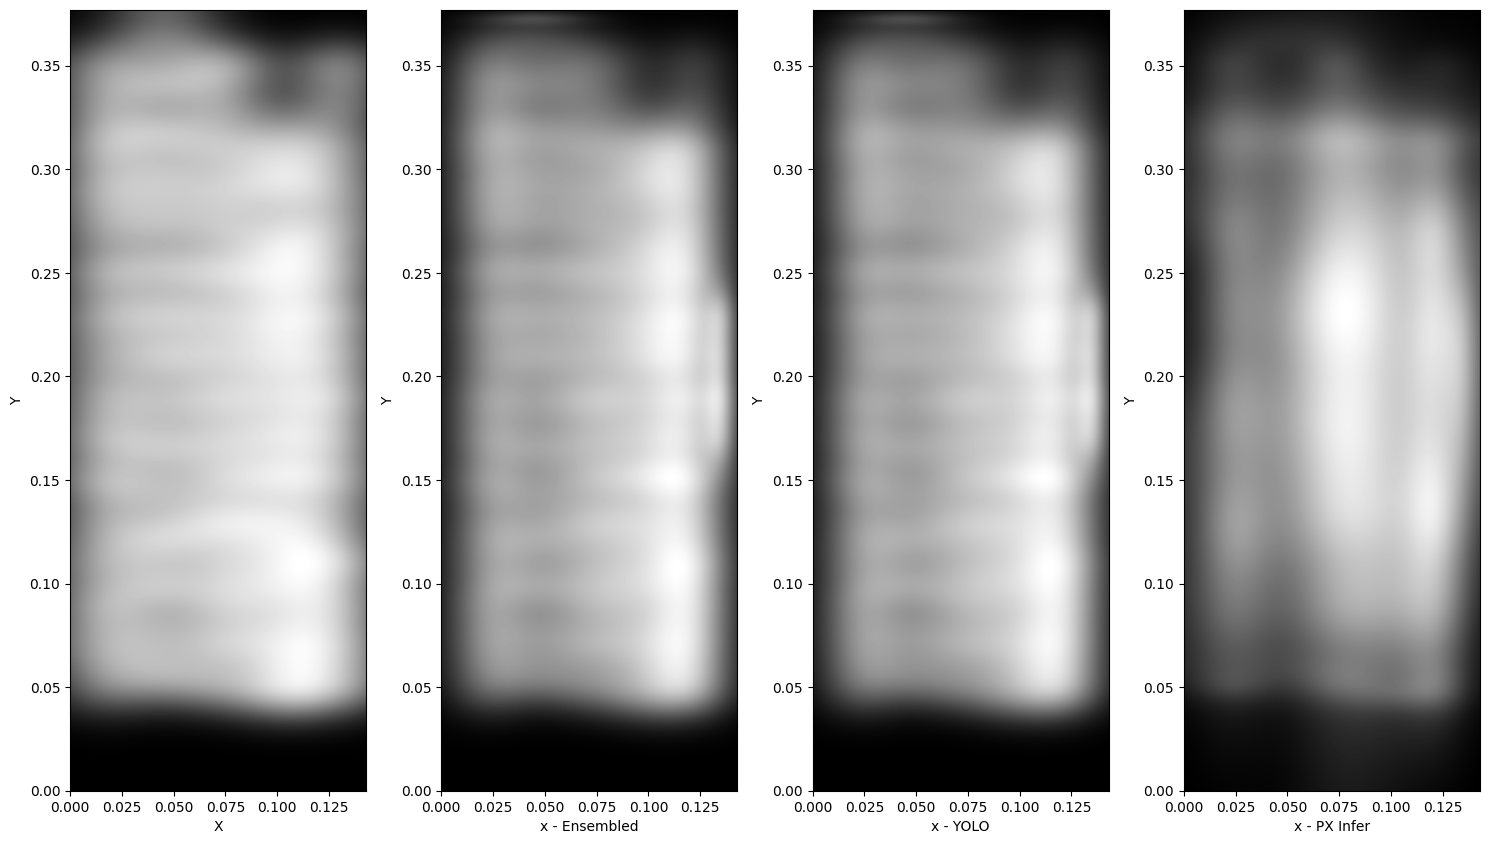

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()